In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# HuggingFace
import datasets

# Imports
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Layer
from keras.layers import (
        Dense,
        Flatten,
        InputLayer,
        BatchNormalization,
        Dropout,
        Input,
        LayerNormalization)
from keras.losses import (
        BinaryCrossentropy,
        CategoricalCrossentropy,
        SparseCategoricalCrossentropy)
from keras.metrics import (
    Accuracy,
    TopKCategoricalAccuracy,
    CategoricalAccuracy,
    SparseCategoricalAccuracy)
from keras.optimizers import Adam

from transformers import BertTokenizerFast, TFBertForSequenceClassification, create_optimizer

In [2]:
# Load train, validation, and test data
train_data, validation_data, test_data = datasets.load_dataset("rotten_tomatoes",
                                                               split=["train", "validation", "test"])

README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [3]:
# Initialize model and tokernizer
MODEL="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(MODEL)

# Function to tokenize text in data
def preprocess_function(data):
  return tokenizer(data["text"],padding=False,truncation=True)

# Tokenizing train data
tokenized_dataset = train_data.map(preprocess_function, batched=True)
tokenized_dataset

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8530
})

In [4]:
from transformers import DataCollatorWithPadding

# Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Convert to tensorflow formatted df
tf_train_dataset = tokenized_dataset.to_tf_dataset(
    columns = ["input_ids", "token_type_ids", "attention_mask", "label"],
    #label_cols = 'label',
    batch_size = 2,
    collate_fn = data_collator,
    shuffle = True
)

In [5]:
# Create bert model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# Training setup
num_epochs = 5
batches_per_epoch = len(tokenized_dataset) // 2
total_train_steps = int(batches_per_epoch * num_epochs)

# Optimizer
#optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
# Optimizer
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

# Compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=optimizer,
              metrics=['accuracy'])

# Optimizer
# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
#     amsgrad=False,
#     weight_decay=None,
#     clipnorm=None,
#     clipvalue=None,
#     global_clipnorm=None,
#     use_ema=False,
#     ema_momentum=0.99,
#     ema_overwrite_frequency=None,
#     name='adam'
# )

In [7]:
# Prep testing set

# Tokenizing train data
tokenized_test_dataset = test_data.map(preprocess_function, batched=True)

# Convert to tensorflow formatted df
tf_test_dataset = tokenized_test_dataset.to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask", "label"],
    #label_cols = 'label',
    batch_size=2,
    collate_fn=data_collator,
    shuffle=True
)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [8]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'token_type_ids':dataset['token_type_ids'],
          'attention_mask':dataset['attention_mask']},dataset['labels']

tf_train_dataset=tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_test_dataset=tf_test_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

In [9]:
# Model training
with tf.device("/gpu:0"):
    history = model.fit(
        tf_train_dataset,
        validation_data=tf_test_dataset,
        epochs=5
    )

Epoch 1/5
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1733013812.173492      86 service.cc:145] XLA service 0x7d809c731210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733013812.173537      86 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733013812.173541      86 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733013812.437570      86 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4265/4265 [==============================] - 353s 67ms/step - loss: 0.5559 - accuracy: 0.5324 - val_loss: 0.3716 - val_accuracy: 0.2702
Epoch 2/5
4265/4265 [==============================] - 265s 62ms/step - loss: 0.4760 - accuracy: 0.5297 - val_loss: 0.4909 - val_accuracy: 0.7336
Epoch 3/5
4265/4265 [==============================] - 266s 62ms/step - loss: 0.2968 - accuracy: 0.5733 - val_loss: 0.7313 - val_accuracy: 0.8049
Epoch 4/5
4265/4265 [==============================] - 265s 62ms/step - loss: 0.2014 - accuracy: 0.7061 - val_loss: 0.9991 - val_accuracy: 0.8189
Epoch 5/5
4265/4265 [==============================] - 265s 62ms/step - loss: 0.1244 - accuracy: 0.8025 - val_loss: 1.4346 - val_accuracy: 0.8452


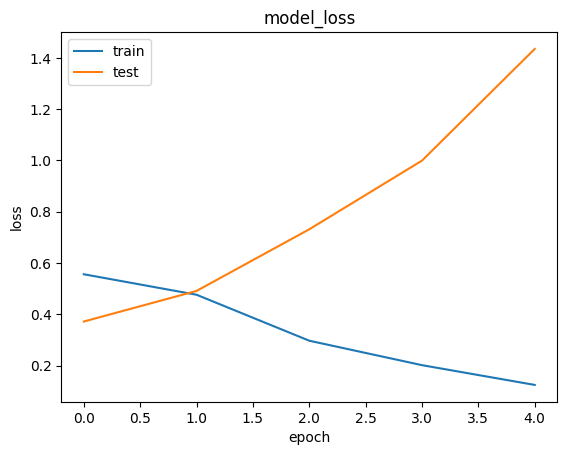

In [10]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

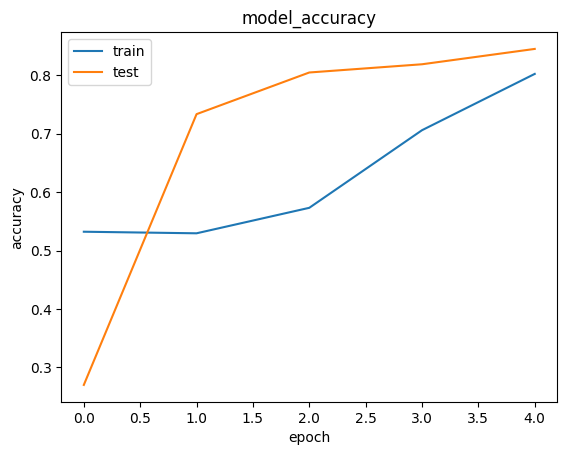

In [11]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()